In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = tf.keras.utils.get_file('potato_photos', origin="https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/v4w72bsts5-1.zip", untar=False)
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

PosixPath('/Users/pawel/.keras/datasets/potato_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

430


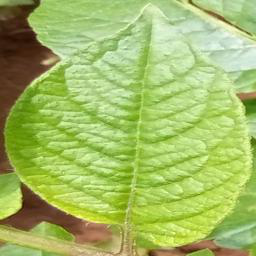

In [5]:
healthy = list(data_dir.glob('Healthy/*'))
PIL.Image.open(str(healthy[0]))

67


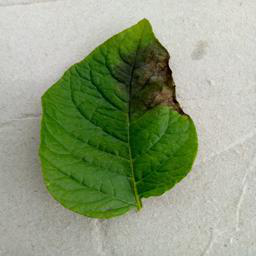

In [6]:
Late_Blight = list(data_dir.glob('Late_Blight/*'))
print(len(Late_Blight));
PIL.Image.open(str(Late_Blight[0]))

In [7]:
batch_size = 32
img_height = 256
img_width = 256

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 430 files belonging to 2 classes.
Using 344 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 430 files belonging to 2 classes.
Using 86 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Late_Blight']


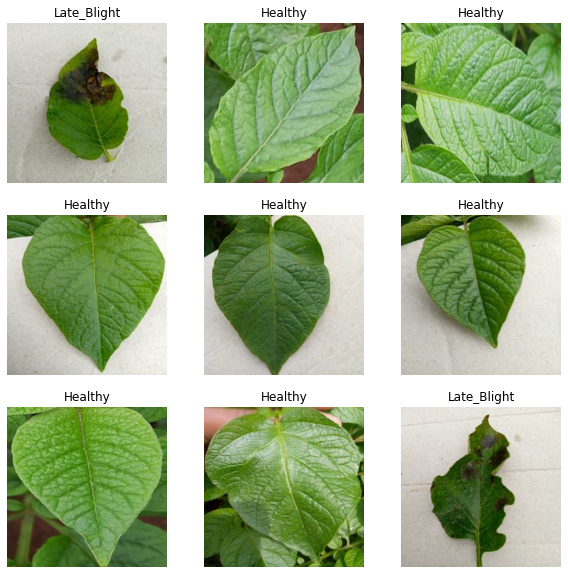

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [16]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 20s 2s/step - loss: 0.5690 - accuracy: 0.8488 - val_loss: 0.1214 - val_accuracy: 0.9884
Epoch 2/10
11/11 [==============================] - 17s 1s/step - loss: 0.0771 - accuracy: 0.9738 - val_loss: 0.0562 - val_accuracy: 0.9767
Epoch 3/10
11/11 [==============================] - 17s 2s/step - loss: 0.0489 - accuracy: 0.9913 - val_loss: 0.0453 - val_accuracy: 0.9884
Epoch 4/10
11/11 [==============================] - 22s 2s/step - loss: 0.0237 - accuracy: 0.9913 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 20s 2s/step - loss: 0.0127 - accuracy: 0.9971 - val_loss: 0.0169 - val_accuracy: 0.9884
Epoch 6/10
11/11 [==============================] - 23s 2s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 26s 2s/step - loss: 9.1919e-04 - accuracy: 1.0000 - val_loss: 1.3565e-04 - val_accuracy: 1.0000
Epoch 8/10
1

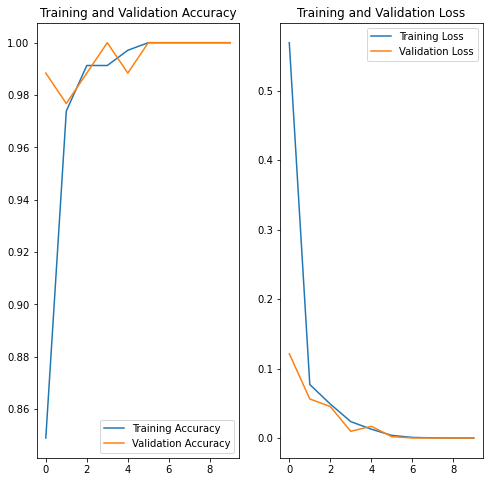

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
potatoes_url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/v4w72bsts5-1.zip"
verification_dir = tf.keras.utils.get_file('potato_photos', origin="https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/v4w72bsts5-1.zip", untar=False)
data_dir = pathlib.Path(verification_dir)

healthy = list(data_dir.glob('Verification/*'))
#PIL.Image.open(str(healthy[0]))

for h in healthy:
    print(h)

    img = keras.preprocessing.image.load_img(
        h, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

/Users/pawel/.keras/datasets/potato_photos/Verification/Late_Blight (463).jpg
This image most likely belongs to Late_Blight with a 100.00 percent confidence.
/Users/pawel/.keras/datasets/potato_photos/Verification/Healthy (224).jpg
This image most likely belongs to Healthy with a 100.00 percent confidence.
/Users/pawel/.keras/datasets/potato_photos/Verification/Late_Blight (454).jpg
This image most likely belongs to Late_Blight with a 100.00 percent confidence.
/Users/pawel/.keras/datasets/potato_photos/Verification/Healthy (215).jpg
This image most likely belongs to Healthy with a 100.00 percent confidence.
/Users/pawel/.keras/datasets/potato_photos/Verification/Late_Blight (473).jpg
This image most likely belongs to Late_Blight with a 100.00 percent confidence.
/Users/pawel/.keras/datasets/potato_photos/Verification/Healthy (220).jpg
This image most likely belongs to Healthy with a 100.00 percent confidence.


In [22]:
model.save('my_model_v10.h5')